# 1. Setup

## 1-1. Library Setup

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8755734838242766598
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8200361596612498292
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
!nvidia-smi

Tue Dec 14 02:52:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [ ]:
basemodel = 'ResNet50'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 2
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1"
T_all_labels = "T0", "T1"

#base_path = ''
base_path = 'gdrive/My Drive/Research_1_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [ ]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_ResNet50_None S_ResNet50_imagenet T_ResNet50_None T_ResNet50_imagenet


['S_ResNet50_imagenet',
 'S_ResNet50_None',
 'T_ResNet50_imagenet',
 'T_ResNet50_None']

In [ ]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [ ]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [ ]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)


In [ ]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [ ]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1920, 128, 128, 3) (1920, 2)
(640, 128, 128, 3) (640, 2)
(640, 128, 128, 3) (640, 2)

(1440, 128, 128, 3) (1440, 2)
(480, 128, 128, 3) (480, 2)
(480, 128, 128, 3) (480, 2)


## 2-2. Image Check

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


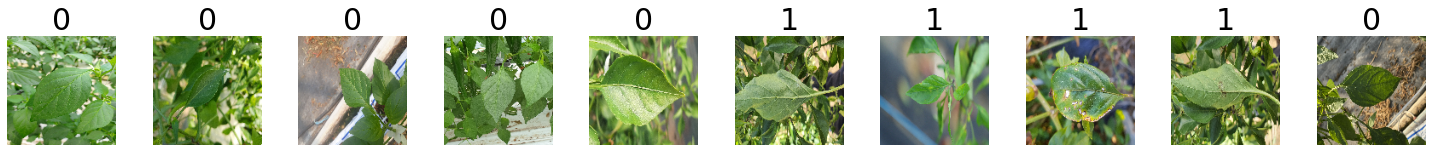

In [ ]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


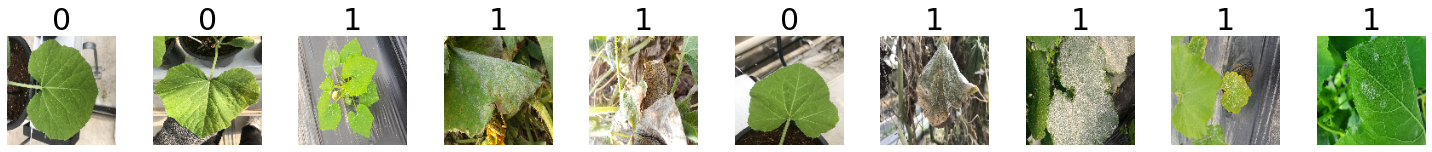

In [ ]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [ ]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.ResNet50 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [ ]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.ResNet50 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [ ]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [ ]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [ ]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 18s 185ms/step - loss: 0.7550 - accuracy: 0.6240 - val_loss: 0.7187 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 4s 138ms/step - loss: 0.3541 - accuracy: 0.8536 - val_loss: 1.1202 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 4s 137ms/step - loss: 0.2460 - accuracy: 0.9057 - val_loss: 0.8412 - val_accuracy: 0.5000
Epoch 4/100
30/30 [==============================] - 4s 137ms/step - loss: 0.1973 - accuracy: 0.9255 - val_loss: 1.0571 - val_accuracy: 0.5000
Epoch 5/100
30/30 [==============================] - 4s 137ms/step - loss: 0.2273 - accuracy: 0.9198 - val_loss: 1.0219 - val_accuracy: 0.5000
Epoch 6/100
30/30 [==============================] - 4s 137ms/step - loss: 0.1485 - accuracy: 0.9495 - val_loss: 1.1696 - val_accuracy: 0.5000
Epoch 7/100
30/30 [==============================] - 4s 137ms/step - loss: 0.1568 - accuracy: 0.9453 - val_loss: 4.5102 - val_accuracy: 0.500

In [ ]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.754969,0.623958,0.718666,0.500000
1,0.354094,0.853646,1.120183,0.500000
2,0.246046,0.905729,0.841169,0.500000
3,0.197273,0.925521,1.057113,0.500000
4,0.227299,0.919792,1.021946,0.500000
...,...,...,...,...
95,0.003076,0.998438,0.492646,0.884375
96,0.014156,0.996354,3.211702,0.590625
97,0.003406,0.999479,1.707713,0.723437
98,0.016628,0.993750,2.081583,0.742188


Minimum validation loss: 0.3185582160949707
Maximum validation accuracy: 0.9312499761581421


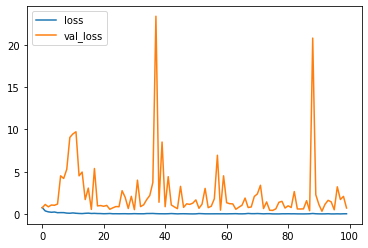

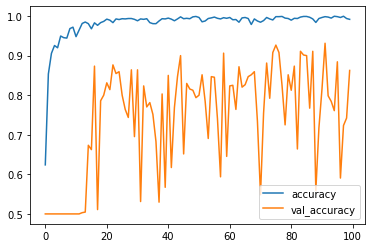

In [ ]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [ ]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 1s 26ms/step - loss: 0.7232 - accuracy: 0.8531
test loss, test acc: [0.7231844663619995, 0.8531249761581421]


In [ ]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

20/20 [==============================] - 1s 23ms/step


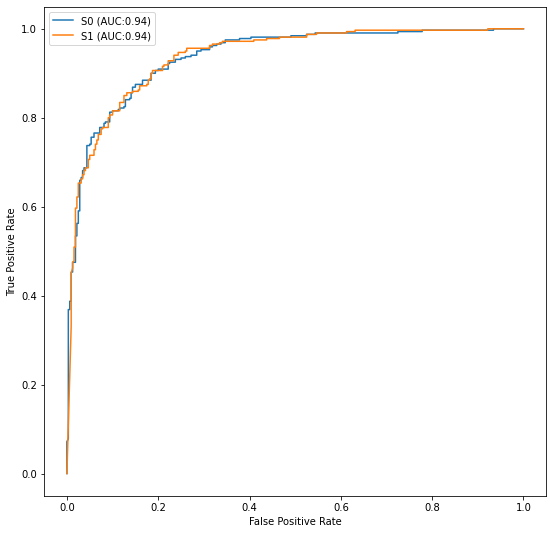

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [ ]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 10s 177ms/step - loss: 0.1908 - accuracy: 0.9198 - val_loss: 47.0143 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 4s 137ms/step - loss: 0.1317 - accuracy: 0.9656 - val_loss: 6809.9937 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 4s 138ms/step - loss: 0.1199 - accuracy: 0.9594 - val_loss: 6678.1157 - val_accuracy: 0.5000
Epoch 4/100
30/30 [==============================] - 4s 137ms/step - loss: 0.0696 - accuracy: 0.9750 - val_loss: 4340.9521 - val_accuracy: 0.5000
Epoch 5/100
30/30 [==============================] - 4s 137ms/step - loss: 0.0448 - accuracy: 0.9828 - val_loss: 10.7640 - val_accuracy: 0.5000
Epoch 6/100
30/30 [==============================] - 4s 137ms/step - loss: 0.0236 - accuracy: 0.9932 - val_loss: 5.2804 - val_accuracy: 0.5000
Epoch 7/100
30/30 [==============================] - 4s 138ms/step - loss: 0.0297 - accuracy: 0.9911 - val_loss: 1.7194 - val_accu

In [ ]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.190768,0.919792,47.014332,0.500000
1,0.131671,0.965625,6809.993652,0.500000
2,0.119864,0.959375,6678.115723,0.500000
3,0.069599,0.975000,4340.952148,0.500000
4,0.044755,0.982813,10.763989,0.500000
...,...,...,...,...
70,0.000013,1.000000,0.097056,0.982813
71,0.000027,1.000000,0.094554,0.982813
72,0.000006,1.000000,0.094251,0.984375
73,0.000009,1.000000,0.092480,0.985937


Minimum validation loss: 0.07082781940698624
Maximum validation accuracy: 0.989062488079071


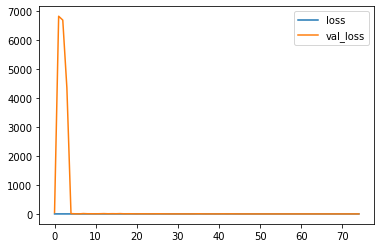

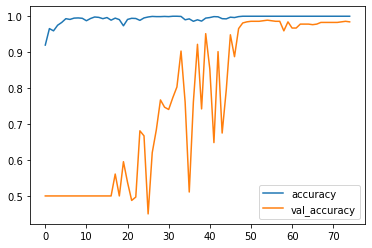

In [ ]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [ ]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 1s 26ms/step - loss: 0.0834 - accuracy: 0.9812
test loss, test acc: [0.08337017148733139, 0.981249988079071]


In [ ]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

20/20 [==============================] - 1s 23ms/step


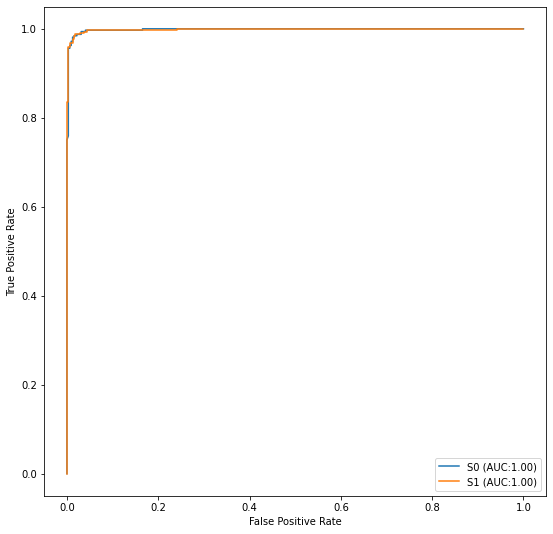

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [ ]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [ ]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 10s 194ms/step - loss: 0.9728 - accuracy: 0.5667 - val_loss: 0.7015 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 3s 135ms/step - loss: 0.3995 - accuracy: 0.8215 - val_loss: 1.0666 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 3s 140ms/step - loss: 0.1437 - accuracy: 0.9521 - val_loss: 0.6821 - val_accuracy: 0.7188
Epoch 4/100
23/23 [==============================] - 3s 135ms/step - loss: 0.1382 - accuracy: 0.9444 - val_loss: 1.8371 - val_accuracy: 0.5000
Epoch 5/100
23/23 [==============================] - 3s 135ms/step - loss: 0.0423 - accuracy: 0.9861 - val_loss: 4.8338 - val_accuracy: 0.5000
Epoch 6/100
23/23 [==============================] - 3s 135ms/step - loss: 0.0889 - accuracy: 0.9660 - val_loss: 4.0011 - val_accuracy: 0.5000
Epoch 7/100
23/23 [==============================] - 3s 134ms/step - loss: 0.0381 - accuracy: 0.9875 - val_loss: 7.7867 - val_accuracy: 0.500

In [ ]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.972759,0.566667,0.701498,0.500000
1,0.399451,0.821528,1.066638,0.500000
2,0.143680,0.952083,0.682086,0.718750
3,0.138213,0.944444,1.837068,0.500000
4,0.042271,0.986111,4.833761,0.500000
...,...,...,...,...
72,0.024790,0.993056,1.819627,0.770833
73,0.032733,0.990278,33.957790,0.593750
74,0.020869,0.993056,2.080700,0.918750
75,0.009169,0.997917,0.902711,0.939583


Minimum validation loss: 0.05570898950099945
Maximum validation accuracy: 0.987500011920929


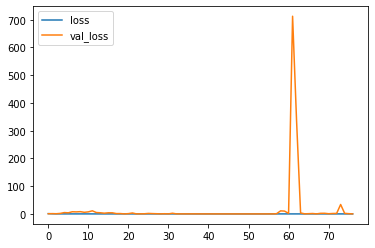

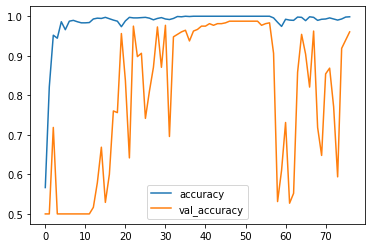

In [ ]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [ ]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 1s 25ms/step - loss: 0.0314 - accuracy: 0.9937
test loss, test acc: [0.03144572675228119, 0.9937499761581421]


In [ ]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

15/15 [==============================] - 1s 23ms/step


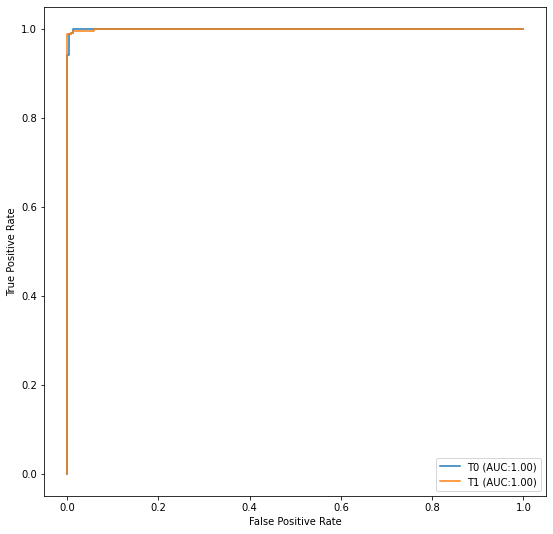

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [ ]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [ ]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 9s 186ms/step - loss: 0.1344 - accuracy: 0.9479 - val_loss: 167.5956 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 3s 135ms/step - loss: 0.0359 - accuracy: 0.9882 - val_loss: 62.6028 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 3s 135ms/step - loss: 0.0854 - accuracy: 0.9826 - val_loss: 75.6843 - val_accuracy: 0.5000
Epoch 4/100
23/23 [==============================] - 3s 136ms/step - loss: 0.0591 - accuracy: 0.9819 - val_loss: 1.3287 - val_accuracy: 0.5000
Epoch 5/100
23/23 [==============================] - 3s 136ms/step - loss: 0.0264 - accuracy: 0.9917 - val_loss: 8.0054 - val_accuracy: 0.5000
Epoch 6/100
23/23 [==============================] - 3s 136ms/step - loss: 0.0199 - accuracy: 0.9931 - val_loss: 416.5827 - val_accuracy: 0.5000
Epoch 7/100
23/23 [==============================] - 3s 136ms/step - loss: 0.0270 - accuracy: 0.9910 - val_loss: 6.6682 - val_accuracy: 

In [ ]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.134383,0.947917,167.595566,0.50000
1,0.035858,0.988194,62.602802,0.50000
2,0.085407,0.982639,75.684349,0.50000
3,0.059134,0.981944,1.328727,0.50000
4,0.026386,0.991667,8.005377,0.50000
5,0.019893,0.993056,416.582672,0.50000
6,0.026955,0.990972,6.668188,0.50000
7,0.011074,0.999306,0.758697,0.50000
8,0.014092,0.997917,0.830090,0.50000
9,0.026300,0.993056,0.972130,0.50000


Minimum validation loss: 0.7093594074249268
Maximum validation accuracy: 0.5


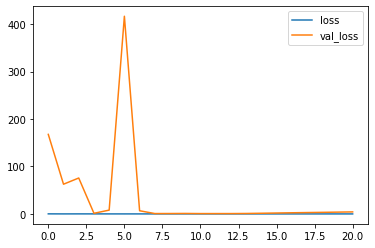

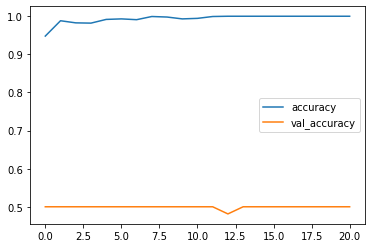

In [ ]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [ ]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 1s 27ms/step - loss: 167.1273 - accuracy: 0.5000
test loss, test acc: [167.12733459472656, 0.5]


In [ ]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

15/15 [==============================] - 1s 24ms/step


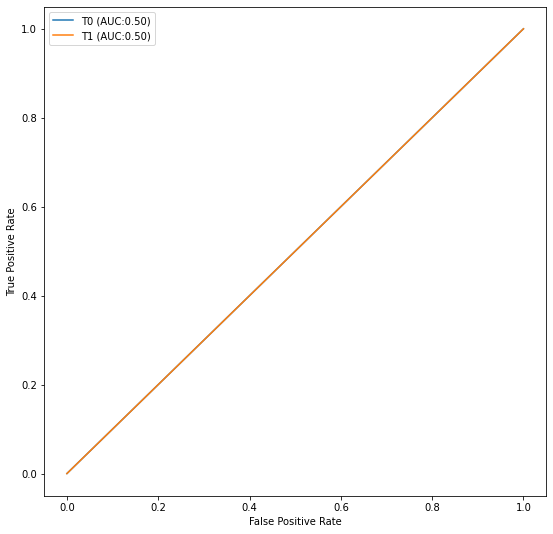

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [ ]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_ResNet50_None
test loss, test acc: [0.7231844663619995, 0.8531249761581421]


In [ ]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_ResNet50_imagenet
test loss, test acc: [0.08337017148733139, 0.981249988079071]


In [ ]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_ResNet50_None
test loss, test acc: [0.03144572675228119, 0.9937499761581421]


In [ ]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_ResNet50_imagenet
test loss, test acc: [167.12733459472656, 0.5]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [ ]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_ResNet50_None →→→ Target Test
15/15 [==============================] - 0s 26ms/step - loss: 1.7416 - accuracy: 0.7333
test loss, test acc: [1.741608738899231, 0.7333333492279053]


In [ ]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_ResNet50_imagenet →→→ Target Test
15/15 [==============================] - 0s 26ms/step - loss: 3.9946 - accuracy: 0.5479
test loss, test acc: [3.994616746902466, 0.5479166507720947]


In [ ]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_ResNet50_None →→→ Source Test
20/20 [==============================] - 1s 25ms/step - loss: 2.4681 - accuracy: 0.5953
test loss, test acc: [2.4680867195129395, 0.5953124761581421]


In [ ]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_ResNet50_imagenet →→→ Source Test
20/20 [==============================] - 1s 26ms/step - loss: 164.4355 - accuracy: 0.5000
test loss, test acc: [164.43553161621094, 0.5]


# 6. Model Save 

In [ ]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
